**Importing Stuff**

In [29]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import nltk
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


Downloading stopwords

In [30]:
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading both Training and Testing data

In [31]:
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')

Looking into the Training data.

In [32]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [33]:
alarming_words = [
    'fire', 'flood', 'earthquake', 'hurricane', 'bomb', 'attack', 'crash', 'disaster',
    'emergency', 'accident', 'injured', 'dead', 'death', 'explosion', 'storm', 'tornado',
    'tsunami', 'war', 'terror', 'shooting', 'riot', 'evacuate', 'danger', 'hazard'
]

Text preprocessing

In [34]:
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Keep only letters
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return " ".join(text)

PreProcessed Data

In [35]:
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

In [18]:
train_df.head(10)

,id,keyword,location,text,target,processed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 closed dire...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,im top hill see fire woods
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,theres emergency evacuation happening building...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid tornado coming area


Counting the words.

In [36]:
vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(train_df['cleaned_text'])

In [37]:
# Get word frequencies
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.toarray().sum(axis=0)))
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))


In [38]:
# Top 10 repeated words
print("Top 10 repeated words:", list(sorted_word_freq.items())[:10])

Top 10 repeated words: [('fire', 356), ('like', 350), ('amp', 344), ('get', 255), ('new', 228), ('via', 220), ('news', 213), ('one', 209), ('people', 201), ('time', 181)]


Counting the alarming words

In [39]:
def count_alarming_words(text, alarming_words):
    words = text.split()
    return sum(1 for word in words if word in alarming_words)


train_df['alarming_word_count'] = train_df['cleaned_text'].apply(lambda x: count_alarming_words(x, alarming_words))

In [40]:
# Total alarming words count
alarming_word_total = train_df['alarming_word_count'].sum()
print(f"Total alarming words count: {alarming_word_total}")


Total alarming words count: 2182


Ploting the graph

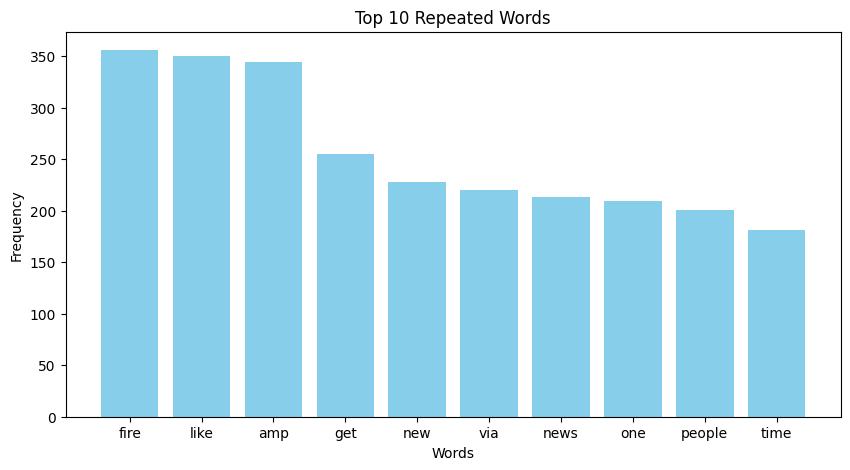

In [52]:
top_repeated = list(sorted_word_freq.items())[:10]
words, counts = zip(*top_repeated)

plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='Skyblue')
plt.title("Top 10 Repeated Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

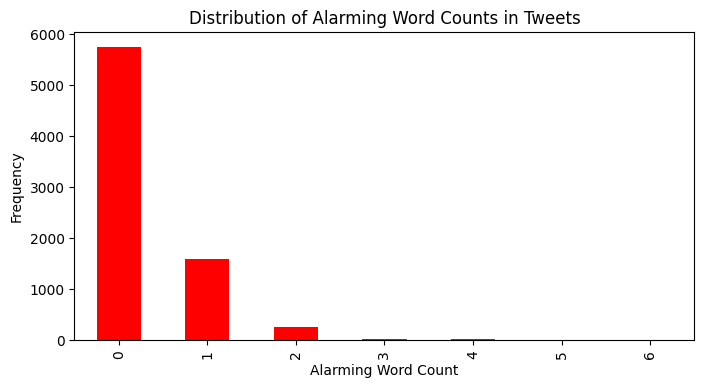

In [53]:
# Bar graph for alarming words count
alarming_word_counts = train_df['alarming_word_count'].value_counts()

plt.figure(figsize=(8, 4))
alarming_word_counts.plot(kind='bar', color='red')
plt.title("Distribution of Alarming Word Counts in Tweets")
plt.xlabel("Alarming Word Count")
plt.ylabel("Frequency")
plt.show()

Training the model.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train_df['cleaned_text']).toarray()
y = train_df['target']

In [58]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "SGD Classifier": SGDClassifier(),
    "Random Forest": RandomForestClassifier()
}

In [62]:
# Train and evaluate models
f1_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1_scores[name] = f1_score(y_val, y_pred)


# Display F1 scores
for model, score in f1_scores.items():
    print(f"{model}: F1 Score = {score:.4f}")

Naive Bayes: F1 Score = 0.7454
Logistic Regression: F1 Score = 0.7405
Decision Tree: F1 Score = 0.6762
SGD Classifier: F1 Score = 0.7500
Random Forest: F1 Score = 0.7244


In [63]:
# Train and evaluate models
f1_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1_scores[name] = f1_score(y_val, y_pred)


In [64]:
# Display F1 scores
for model, score in f1_scores.items():
    print(f"{model}: F1 Score = {score:.4f}")

Naive Bayes: F1 Score = 0.7454
Logistic Regression: F1 Score = 0.7405
Decision Tree: F1 Score = 0.6768
SGD Classifier: F1 Score = 0.7438
Random Forest: F1 Score = 0.7162


Best model selection

In [67]:
best_model_name = max(f1_scores, key=f1_scores.get)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Best Model: Naive Bayes


Making preducation on the test set

In [68]:
test_predictions = best_model.predict(vectorizer.transform(test_df['cleaned_text']).toarray())

Create a result table

In [69]:

result_table = test_df[['id', 'text']].copy()
result_table['prediction'] = test_predictions

In [73]:
from prettytable import PrettyTable

In [74]:
pretty_table = PrettyTable()
pretty_table.field_names = ["ID", "Text", "Prediction"]

for _, row in result_table.head(10).iterrows():
    pretty_table.add_row([row['id'], row['text'][:50] + "...", row['prediction']])  # Truncate long text

print("\nTop 10 Predictions:")
print(pretty_table)


Top 10 Predictions:
+----+-------------------------------------------------------+------------+
| ID |                          Text                         | Prediction |
+----+-------------------------------------------------------+------------+
| 0  |         Just happened a terrible car crash...         |     1      |
| 2  | Heard about #earthquake is different cities, stay ... |     1      |
| 3  | there is a forest fire at spot pond, geese are fle... |     1      |
| 9  |      Apocalypse lighting. #Spokane #wildfires...      |     1      |
| 11 |    Typhoon Soudelor kills 28 in China and Taiwan...   |     1      |
| 12 |         We're shaking...It's an earthquake...         |     1      |
| 21 | They'd probably still show more life than Arsenal ... |     0      |
| 22 |                  Hey! How are you?...                 |     0      |
| 27 |                  What a nice hat?...                  |     0      |
| 29 |                      Fuck off!...                     |     

Downloading results.

In [75]:
from google.colab import files

# Save results to CSV
output_file = 'predictions_with_text.csv'
result_table.to_csv(output_file, index=False)
print(f"\nPredictions saved to '{output_file}'")

# Download the file
print("Downloading the file...")
files.download(output_file)


Predictions saved to 'predictions_with_text.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>